Testing:

CosmosCanvas Error colour map.
Mark Richardson, Gilles Ferrand and Jayanne English.

This 'spectral index error' colour map indicates regions of higher uncertainty in error maps and it is designed as a companion to the create_cmap_specindex module in specindex.py For an example of how the error colour map is used see the panel figures for the B-array configuration for the CHANG-ES catalogue at https://www.queensu.ca/changes/ngc-4157/. 

Regions of high uncertainty are assigned the colours orange through yellow. Towards regions of low uncertainty the colour desaturates to grey. The user can adjust the value at which the desaturation becomes prominant by using the middle_cmap parameter (default = 0.5). The hues for regions of uncertainty can be changed using the H_min and H_max parameters.

This notebook is an exploration for designing the colour map in LCH space in order to provide the functionality of setting this threshold for desaturation. 

Latest version: 2021-07-25 JE edits. 

In [1]:
import numpy as np
import specindex as spx

from colourspace import convert
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib import cm
import matplotlib.pyplot as plt
from colourspace import maps

convertor = 'custom' (illuminant = 'D65')


In [2]:
# Jayanne's original SpecIndex Error Map using RGB
endcolor = '#ff9506'    # light orange for most error
midcolor = '#c9934a'    # grey
startcolor = '#b5b5b5'  # light grey for least error

In [3]:
# Create the cmap using built-in matplotlib commands (not colourspace)
cmap_SI_E = LinearSegmentedColormap.from_list('cmap_SI_E',[startcolor,midcolor, endcolor])
plt.register_cmap(cmap=cmap_SI_E)

loading gamut from /Users/mrichardson/Work/Research/Jayanne/FinalGitDevelopment/colourspace/gamut/Cmax_res10_sRGB.npy


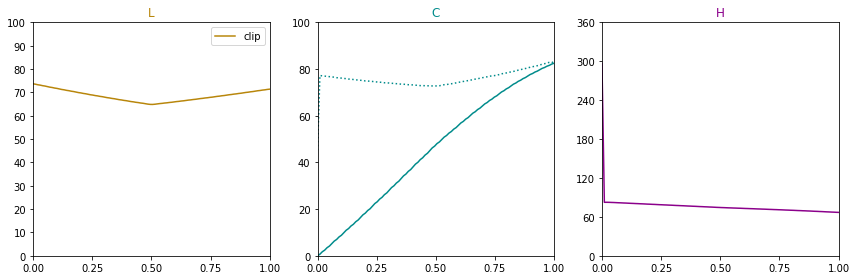

In [4]:
# Let's show the original colour map in LCH space colourspace plot_path function.
axes = maps.plot_path(cmap_SI_E, space='LCH', stack='H', axes=[]  , styles=['-' ], legend_label='clip')

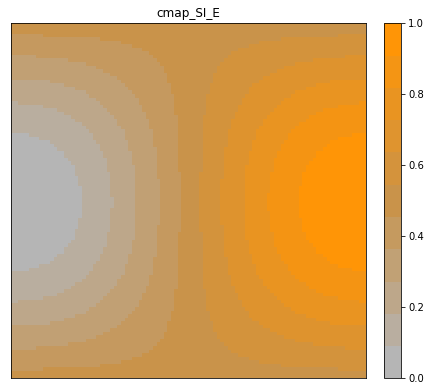

In [5]:
# Let's show the colour map using the test_cmaps function.
figsize_test = (7, 7)
maps.test_cmaps(names=['cmap_SI_E'],figsize=figsize_test,fname="",nsteps=[11])

Now we want to attempt to recreate this purely in LCH. 

Gilles noticed that in L, the above plot looks like it is symmetric about the middle, so starts at an *L_ends* value at the top and bottom of the colour bar, and has a *L_middle* value at the middle.

Gilles noticed that in C, the above plot looks like a linear increase from C=0 at the bottom of the color bar (grey) up to a maximum chroma, *C_max*. 

Finally, Gilles suggested that the eye can't really tell the small change in H since a lot of it happens at low C anyway, and so approximated it as *H_constant*. 

To shift the colourmap so a user could stretch the middle point, we can define a new parameter, *middle_cmap* which by default is 0.5, but you can set it anywhere between 0 and 1 to shift that middle point up or down the colorbar. For constant Hue, this doesn't change the H values, but as *middle_cmap* changes it shifts where *L_middle* is found, and where *C_max/2* is found.

Recall: 
Luminosity == L runs from 0 to 100 (lightest). 
Chroma == C runs from 0 to 100 (most saturated). 
Hue == H are degrees on the colour wheel. 
Light orange (#ff9506) is H = 65 degrees on the GIMP colour wheel which starts with H = zero degrees == Magenta and rotates counterclockwise towards yellow and then green, etc. 

LCH_x are the positions along colour bar (min=0; max=1) while LCH_y are the values that are being mapped. 

In [6]:
# Now we want to attempt to recreate this purely in LCH. 
# 
# Let's parameterize this:
def get_SpecIndex_E_LCH(middle_cmap=0.5):
    L_ends = 72.
    L_middle = 65. 

    C_max = 85.
    C_middle = C_max / 2.
    H_constant = 70.
    LCH_x = {}
    LCH_y = {}

    LCH_x['L'] = [0     , middle_cmap,     1.]
    LCH_y['L'] = [L_ends,    L_middle, L_ends]
    LCH_x['C'] = [0     , middle_cmap,     1.]
    LCH_y['C'] = [0.    ,    C_middle,  C_max]
    LCH_x['H'] = [0         ,         1.]
    LCH_y['H'] = [H_constant, H_constant]
    
    return LCH_x, LCH_y

In [7]:
# Set this parameter on [0:1] to shift middle of colormap. Default is 0.5
middle_cmap = 0.5
LCH_x, LCH_y = get_SpecIndex_E_LCH(middle_cmap)
name_c1 = 'cmap_SI_E_c1'

RGB_SI_E_c1 = maps.make_cmap_segmented(LCH_x,LCH_y,name=name_c1,modes=['clip'],targets=['png'],png_dir='./',out=True)
cm.register_cmap(cmap=ListedColormap(RGB_SI_E_c1['clip'],name_c1), name=name_c1)

loading gamut from /Users/mrichardson/Work/Research/Jayanne/FinalGitDevelopment/colourspace/gamut/Cmax_res10_full.npy
writing .//cmap_cmap_SI_E_c1.png (32x1024)


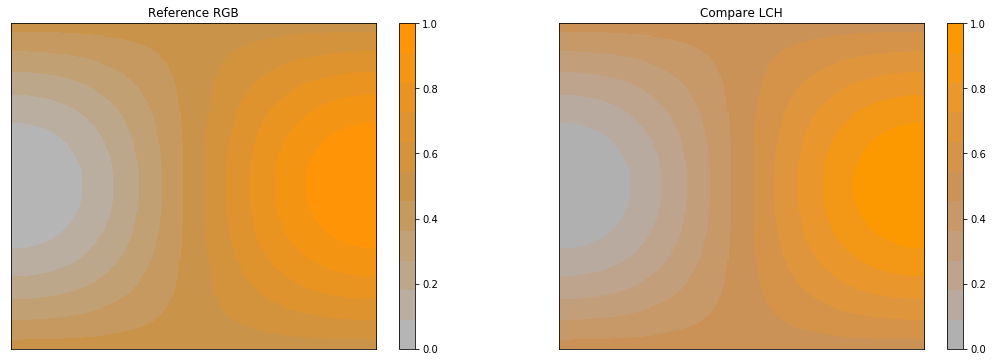

In [8]:
spx.test_cmap_showme_compare(cmap_SI_E,name_c1,0,1,nsteps=11,t1="Reference RGB",t2="Compare LCH")

In [9]:
# Let's make an example with the middle stretch to 75% along the colorbar
# Set this parameter on [0:1] to shift middle of colormap. Default is 0.5
middle_cmap = 0.75
LCH_x, LCH_y = get_SpecIndex_E_LCH(middle_cmap)
name_c75 = 'cmap_SI_E_c75'

RGB_SI_E_c75 = maps.make_cmap_segmented(LCH_x,LCH_y,name=name_c75,modes=['clip'],targets=['png'],png_dir='./',out=True)
cm.register_cmap(cmap=ListedColormap(RGB_SI_E_c75['clip'],name_c75), name=name_c75)

writing .//cmap_cmap_SI_E_c75.png (32x1024)


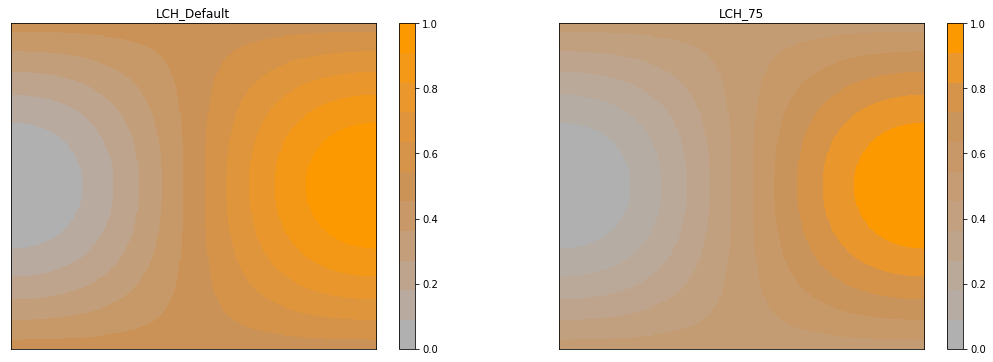

In [10]:
spx.test_cmap_showme_compare(name_c1,name_c75,0,1,nsteps=11,t1="LCH_Default",t2="LCH_75")

In [11]:
# Feel free to play around with this here

I want to do one last option for LCH defined SpecIndec error map, which has H change linearly from *H_min* to *H_max*. 

In [12]:
# Now we want to attempt to recreate this purely in LCH. 
# 
# Let's parameterize this:
def get_SpecIndex_E_LCH2(middle_cmap=0.5):
    L_ends = 72.
    L_middle = 65. 

    C_max = 85.
    C_middle = C_max / 2.
    H_min = 90.
    H_max = 70.
    H_middle = 0.5*(H_min + H_max)
    LCH_x = {}
    LCH_y = {}

    LCH_x['L'] = [0     , middle_cmap,     1.]
    LCH_y['L'] = [L_ends,    L_middle, L_ends]
    LCH_x['C'] = [0     , middle_cmap,     1.]
    LCH_y['C'] = [0.    ,    C_middle,  C_max]
    LCH_x['H'] = [0     , middle_cmap,     1.]
    LCH_y['H'] = [H_min , H_middle   ,  H_max]
    
    return LCH_x, LCH_y

In [13]:
# Set this parameter on [0:1] to shift middle of colormap. Default is 0.5
middle_cmap = 0.5
LCH_x, LCH_y = get_SpecIndex_E_LCH2(middle_cmap)
name_c2 = 'cmap_SI_E_c2'

RGB_SI_E_c2 = maps.make_cmap_segmented(LCH_x,LCH_y,name=name_c2,modes=['clip'],targets=['png'],png_dir='./',out=True)
cm.register_cmap(cmap=ListedColormap(RGB_SI_E_c2['clip'],name_c2), name=name_c2)

writing .//cmap_cmap_SI_E_c2.png (32x1024)


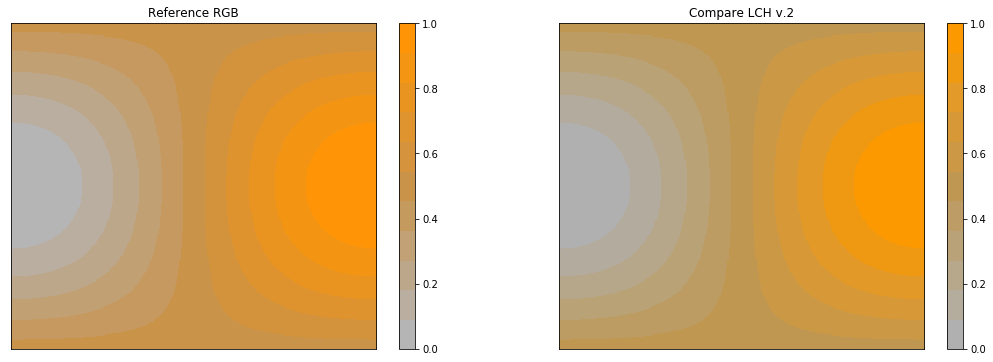

In [14]:
# Compare new LCH approach with original RGB
spx.test_cmap_showme_compare(cmap_SI_E,name_c2,0,1,nsteps=11,t1="Reference RGB",t2="Compare LCH v.2")

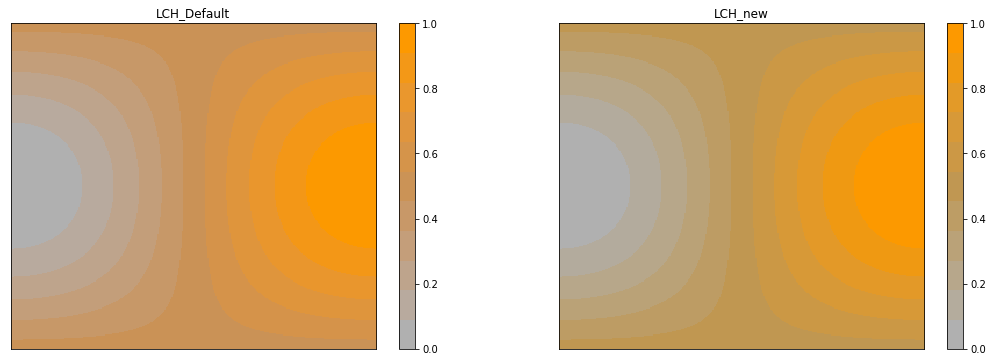

In [15]:
# Compare new LCH approach with first LCH approach
spx.test_cmap_showme_compare(name_c1,name_c2,0,1,nsteps=11,t1="LCH_Default",t2="LCH_new")

In [16]:
# Let's make an example with the new LCH approach, and with the middle stretch to 75% along the colorbar
# Set this parameter on [0:1] to shift middle of colormap. Default is 0.5
middle_cmap = 0.75
LCH_x, LCH_y = get_SpecIndex_E_LCH2(middle_cmap)
name_c2_75 = 'cmap_SI_E_c2_75'

RGB_SI_E_c2_75 = maps.make_cmap_segmented(LCH_x,LCH_y,name=name_c2_75,modes=['clip'],targets=['png'],png_dir='./',out=True)
cm.register_cmap(cmap=ListedColormap(RGB_SI_E_c2_75['clip'],name_c2_75), name=name_c2_75)

writing .//cmap_cmap_SI_E_c2_75.png (32x1024)


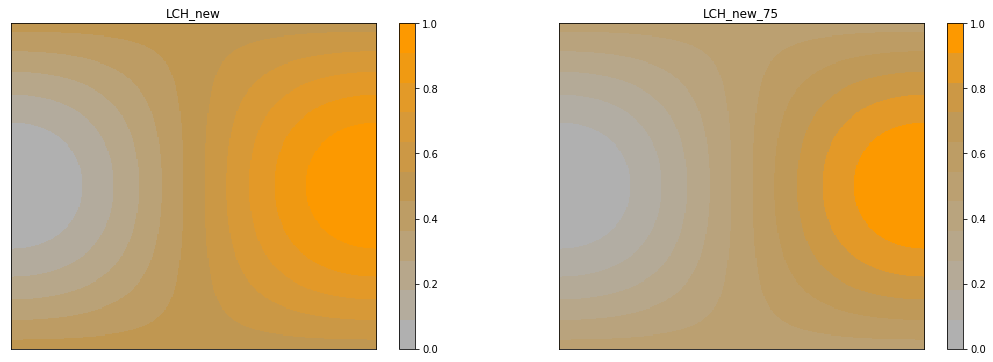

In [17]:
spx.test_cmap_showme_compare(name_c2,name_c2_75,0,1,nsteps=11,t1="LCH_new",t2="LCH_new_75")

Let's try this on data from CHANG-ES. Downloaded error map from https://www.queensu.ca/changes/ngc-3079/ B/L to C/C spectral index error with UVtap (PBcor).  Placed in example_data/ folder.

In [18]:
import galfits as gal

In [19]:
# Set galaxy information
name='N3079'
title='NGC 3079'
fits_file="example_data/SpecIndexError_N3079.FITS"
RA = [10., 1., 57.8]    # hh.mm.ss
DEC = [55., 40., 47.0] # deg.mm.ss
RADIUS = 0.04 # degrees
shift = [0.0, 0.2/60.] # degrees

# Range of values in the error map.
min_value = 0.0 
max_value = 0.35
mid_value = 0.5*(max_value - min_value)


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


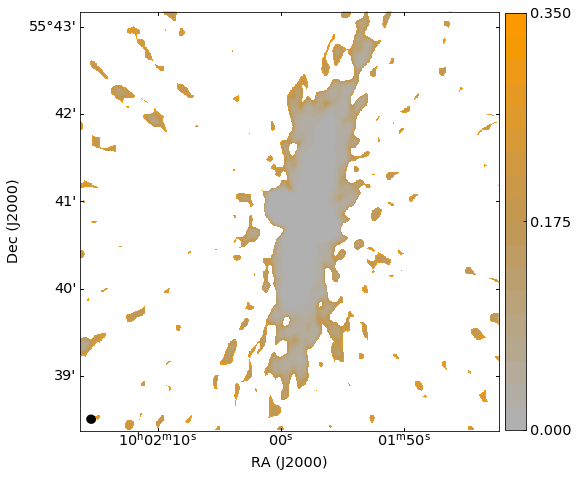

In [20]:
# Plot galaxy
ticks = [min_value,mid_value,max_value]
nsteps=18

# Select the colour map.
galcmap = name_c2

fig,ax = gal.plot_galaxy(fits_file,RA,DEC,RADIUS,shift,min_value,max_value,galcmap,ticks=ticks,nsteps=nsteps)


fig.savefig('errorPlot.png')

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


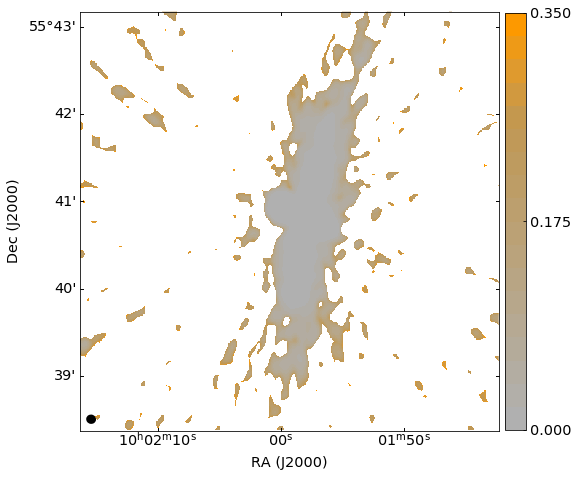

In [21]:
# Select the colour map.
galcmap = name_c2_75

fig,ax = gal.plot_galaxy(fits_file,RA,DEC,RADIUS,shift,min_value,max_value,galcmap,ticks=ticks,nsteps=nsteps)


fig.savefig('errorPlot2.png')

In [22]:
# Let's make an example with the new LCH approach, and with the middle stretch to 25% along the colorbar
# Set this parameter on [0:1] to shift middle of colormap. Default is 0.5
middle_cmap = 0.25
LCH_x, LCH_y = get_SpecIndex_E_LCH2(middle_cmap)
name_c2_25 = 'cmap_SI_E_c2_25'

RGB_SI_E_c2_25 = maps.make_cmap_segmented(LCH_x,LCH_y,name=name_c2_25,modes=['clip'],targets=['png'],png_dir='./',out=True)
cm.register_cmap(cmap=ListedColormap(RGB_SI_E_c2_25['clip'],name_c2_25), name=name_c2_25)

writing .//cmap_cmap_SI_E_c2_25.png (32x1024)


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


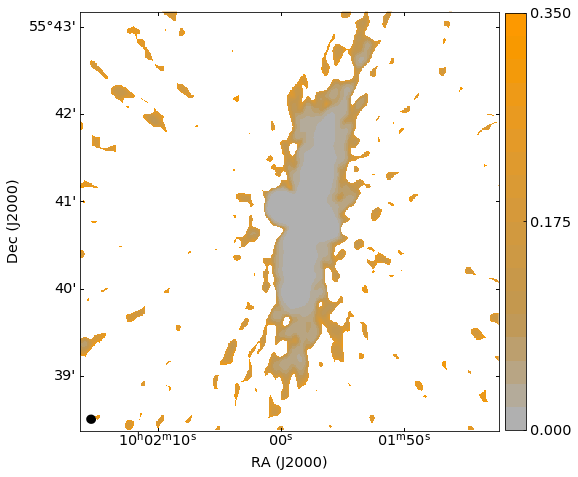

In [23]:
# Select the colour map.
galcmap = name_c2_25

fig,ax = gal.plot_galaxy(fits_file,RA,DEC,RADIUS,shift,min_value,max_value,galcmap,ticks=ticks,nsteps=nsteps)


fig.savefig('errorPlot3.png')

In [24]:
# Now we want to attempt to recreate this purely in LCH. 
# 
# Let's parameterize this:
def get_SpecIndex_E_LCH3(middle_cmap=0.5, H_min = 90., H_max = 70.):
    L_ends = 72.
    L_middle = 65. 

    C_max = 85.
    C_middle = C_max / 2.
    # H_min = 90.
    # H_max = 70.
    H_middle = 0.5*(H_min + H_max)
    LCH_x = {}
    LCH_y = {}

    LCH_x['L'] = [0     , middle_cmap,     1.]
    LCH_y['L'] = [L_ends,    L_middle, L_ends]
    LCH_x['C'] = [0     , middle_cmap,     1.]
    LCH_y['C'] = [0.    ,    C_middle,  C_max]
    LCH_x['H'] = [0     , middle_cmap,     1.]
    LCH_y['H'] = [H_min , H_middle   ,  H_max]
    
    return LCH_x, LCH_y

In [25]:
# Let's make an example with the new LCH approach, and with the middle stretch to 25% along the colorbar
# Set this parameter on [0:1] to shift middle of colormap. Default is 0.5
# ALSO TEST CHANGING THE COLOUR. I do not like the colour scheme -- I'm just showing how the parameters work. 
# This is a functionality that I would like. 
middle_cmap = 0.25
H_min =  180.0  
H_max = 300.0
LCH_x, LCH_y = get_SpecIndex_E_LCH3(middle_cmap, H_min, H_max)
name_c2_25_H0 = 'cmap_SI_E_c2_25_H0'

RGB_SI_E_c2_25_H0 = maps.make_cmap_segmented(LCH_x,LCH_y,name=name_c2_25_H0,modes=['clip'],targets=['png'],png_dir='./',out=True)
cm.register_cmap(cmap=ListedColormap(RGB_SI_E_c2_25_H0['clip'],name_c2_25_H0), name=name_c2_25_H0)

writing .//cmap_cmap_SI_E_c2_25_H0.png (32x1024)


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


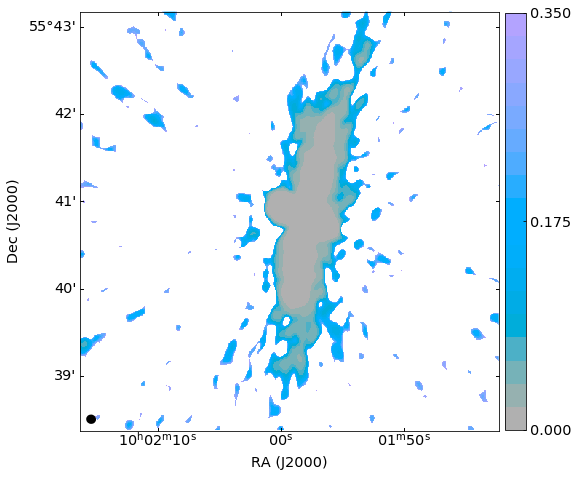

In [26]:
# Select the colour map.
galcmap = name_c2_25_H0 

fig,ax = gal.plot_galaxy(fits_file,RA,DEC,RADIUS,shift,min_value,max_value,galcmap,ticks=ticks,nsteps=nsteps)


fig.savefig('errorPlot4.png')


In [45]:
# Now we want to attempt to recreate this purely in LCH. 
# 
# Let's parameterize this:
def get_SpecIndex_E_LCH_all(L_ends=72., L_middle=65., C_max=85., H_min=70., H_max = 70., middle_cmap=0.5):
    C_middle = C_max / 2.
    H_middle = 0.5*(H_min + H_max)
    LCH_x = {}
    LCH_y = {}

    LCH_x['L'] = [0     , middle_cmap,     1.]
    LCH_y['L'] = [L_ends,    L_middle, L_ends]
    LCH_x['C'] = [0     , middle_cmap,     1.]
    LCH_y['C'] = [0.    ,    C_middle,  C_max]
    LCH_x['H'] = [0     , middle_cmap,     1.]
    LCH_y['H'] = [H_min , H_middle   ,  H_max]
    
    return LCH_x, LCH_y

In [46]:
# Let's make an example with the new LCH approach, and with the middle stretch to 25% along the colorbar
# Set this parameter on [0:1] to shift middle of colormap. Default is 0.5
# ALSO TEST CHANGING THE LUMINOSITY. 
# We want to allow variation in the high error (so above middle_cmap) to be seen.
middle_cmap = 0.25
L_middle =  50.
LCH_x, LCH_y = get_SpecIndex_E_LCH_all(middle_cmap=middle_cmap, L_middle=L_middle)
name_c2_25_Lm = 'cmap_SI_E_c2_25_Lm'

RGB_SI_E_c2_25_Lm = maps.make_cmap_segmented(LCH_x,LCH_y,name=name_c2_25_Lm,modes=['clip'],targets=['png'],png_dir='.',out=True)
cm.register_cmap(cmap=ListedColormap(RGB_SI_E_c2_25_Lm['clip'],name_c2_25_Lm), name=name_c2_25_Lm)

writing ./cmap_cmap_SI_E_c2_25_Lm.png (32x1024)


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


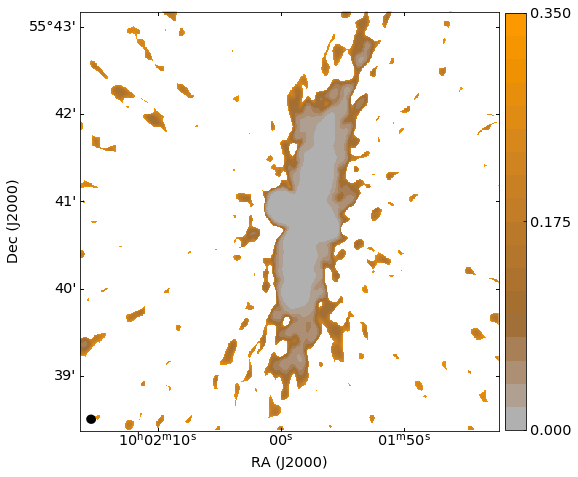

In [47]:
# Select the colour map.
galcmap = name_c2_25_Lm

fig,ax = gal.plot_galaxy(fits_file,RA,DEC,RADIUS,shift,min_value,max_value,galcmap,ticks=ticks,nsteps=nsteps)


fig.savefig('errorPlot5.png')


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


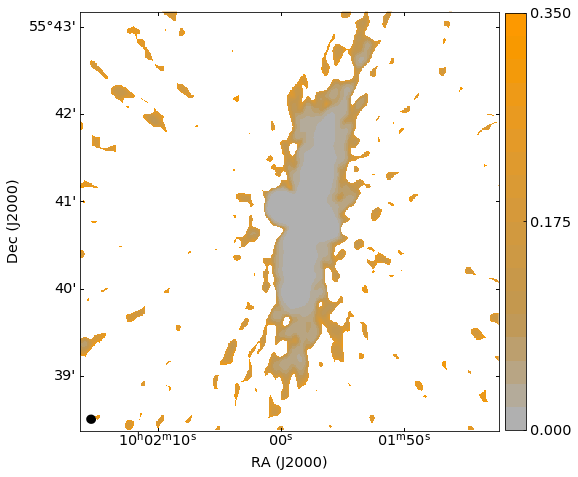

In [39]:
# Select the colour map.
galcmap = name_c2_25

fig,ax = gal.plot_galaxy(fits_file,RA,DEC,RADIUS,shift,min_value,max_value,galcmap,ticks=ticks,nsteps=nsteps)


fig.savefig('errorPlot3.png')